In [101]:
import warnings
from functools import partial

import numpy as np
import pandas as pd
import networkx as nx
import plotly.graph_objs as go
from tqdm.auto import tqdm

# Create Network DataFrame

In [5]:
faces_df = pd.read_csv('./data/faces.csv', index_col=0)
character_df = faces_df[faces_df['character'].notna()]

In [32]:
def f(row,
      df):
    temp = df['frame_num'].map(lambda x: abs(frame_num - x))
    datum = {
         'min': temp.min(), 
         'max': temp.max(),
         'mean': int(round(temp.mean(), 0)),
         'median': int(temp.median())
        }
    return datum

In [33]:
def calc_frame_distance(a,
                        b,
                        df):
    a_df = character_df[character_df['character'] == a]
    b_df = character_df[character_df['character'] == b]
    func = partial(f, df=b_df)
    tqdm().pandas()
    temp = a_df.progress_apply(func, axis=1)
    data = []
    for x in temp:
        datum['character'] = a
        datum['target'] = b
        data.append(datum)
    return data

In [34]:
a = 'Carrie Mathison'
b = 'Peter Quinn'
df = pd.DataFrame(calc_frame_distance(a, b, character_df))
df.head()

0it [00:00, ?it/s]

  0%|          | 0/33897 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
a = 'Carrie Mathison'
b = 'Saul Berenson'
episode_df = character_df[(character_df['season'] == 1) & (character_df['episode'])]
a_df = episode_df[episode_df['character'] == a]
b_df = episode_df[episode_df['character'] == b]
print(a_df.shape[0])
print(b_df.shape[0])

2461
959


In [86]:
def func(a,
         b,
         season,
         episode,
         df):
    episode_df = character_df[(character_df['season'] == season) & (character_df['episode'] == episode)]
    a_df = episode_df[episode_df['character'] == a]
    b_df = episode_df[episode_df['character'] == b]

    a_df = a_df[['character', 'frame_num']].rename({'character': 'character_a', 
                                                'frame_num': 'frame_num_a'}, axis=1)
    b_df = b_df[['character', 'frame_num']].rename({'character': 'character_b', 
                                                    'frame_num': 'frame_num_b'}, axis=1)
    c_df = pd.concat([a_df, b_df], axis=1)
    c_df['character_a'] = c_df['character_a'].ffill()
    c_df['frame_num_a'] = c_df['frame_num_a'].ffill()
    c_df['character_b'] = c_df['character_b'].bfill()
    c_df['frame_num_b'] = c_df['frame_num_b'].bfill()

    c_df['distance'] = abs(c_df['frame_num_b'] - c_df['frame_num_a'])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        datum = {
            'character': a,
            'target': b,
            'season': season,
            'episode': episode,
            'min': c_df['distance'].min() if c_df.shape[0] > 0 else np.nan,
            'max': c_df['distance'].max() if c_df.shape[0] > 0 else np.nan,
            'mean': c_df['distance'].mean() if c_df.shape[0] > 0 else np.nan,
            'median': c_df['distance'].median() if c_df.shape[0] > 0 else np.nan
            }
        return datum

In [97]:
characters = character_df['character'].unique()

data = []
pb = tqdm(total=8 * 12 * characters.shape[0] * characters.shape[0])
for a in list(characters):
    for b in characters:
        if a == b:
            continue
        for season in range(1, 9):
            for episode in range(1, 13):
                datum = func(a,
                             b,
                             season,
                             episode,
                             character_df)
                data.append(datum)
                pb.update()

  0%|          | 0/457056 [00:00<?, ?it/s]

In [98]:
network_df = pd.DataFrame(data)
network_df.head()

,character,target,season,episode,min,max,mean,median
0,Carrie Mathison,David Estes,1,1,24.0,74664.0,42917.073930,48360.0
1,Carrie Mathison,David Estes,1,2,504.0,45000.0,22087.709369,20928.0
2,Carrie Mathison,David Estes,1,3,120.0,66312.0,35896.589641,32700.0
3,Carrie Mathison,David Estes,1,4,NaN,NaN,NaN,NaN
4,Carrie Mathison,David Estes,1,5,192.0,76392.0,37476.438430,32760.0


In [99]:
network_df.to_csv('./data/network.csv')

# Create Network Map

## Example Network Maps

### Networkx

In [112]:
G = nx.random_geometric_graph(200, 0.125)

In [103]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

In [104]:
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

In [105]:
node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

In [106]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [108]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

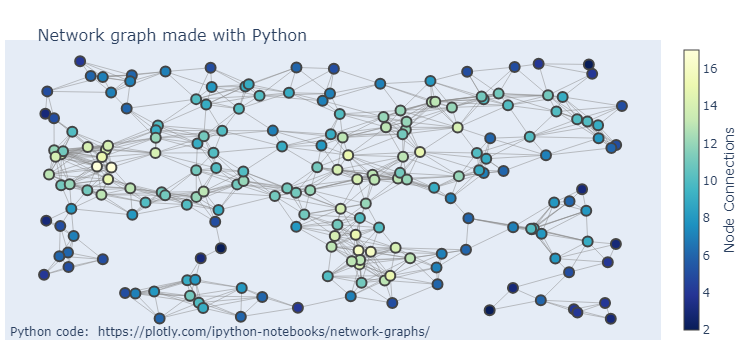

In [109]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

### Tutorial

In [186]:
network_counts = network_df[network_df.notna()]
counts = faces_df['character'].value_counts().sort_values(ascending=False).iloc[:10]
network_counts = network_counts[(network_counts['character'].isin(counts.index)) &
                                (network_counts['target'].isin(counts.index))]
# network_counts = network_counts.merge(counts,
#                                   how='inner',
#                                   right_index=True,
#                                   left_on='character')
# network_counts = network_counts.merge(counts,
#                                   how='inner',
#                                   right_index=True,
#                                   left_on='target')

network_counts.head()

,character,target,season,episode,min,max,mean,median
96,Carrie Mathison,Saul Berenson,1,1,72.0,65592.0,34107.871921,38136.0
97,Carrie Mathison,Saul Berenson,1,2,24.0,69672.0,40146.259965,42024.0
98,Carrie Mathison,Saul Berenson,1,3,48.0,66624.0,36963.890710,41256.0
99,Carrie Mathison,Saul Berenson,1,4,NaN,NaN,NaN,NaN
100,Carrie Mathison,Saul Berenson,1,5,96.0,76128.0,37502.217090,39408.0


In [187]:
to_list = network_counts['character'].tolist()
from_list = network_counts['target'].tolist()

In [188]:
G = nx.Graph()
node_list = network_counts['character'].tolist()
for i in range(network_counts.shape[0]):
    G.add_node(node_list[i])
    G.add_edges_from([(from_list[i], to_list[i])])

In [189]:
pos = nx.spring_layout(G, k=0.5, iterations=100)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

In [190]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

In [191]:
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='pinkyl',
        reversescale=True,
        color=[],
        size=37,
        colorbar=dict(
            thickness=1,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color'] += tuple([len(adjacencies[1])])
    node_info = adjacencies[0]
    node_trace['text'] += tuple([node_info])

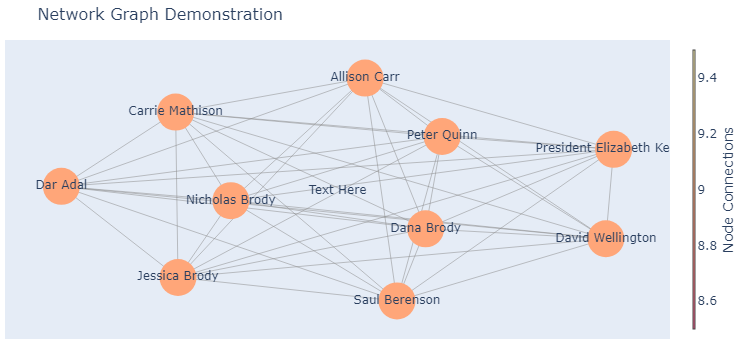

In [192]:
title = "Network Graph Demonstration"
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                title=title,
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=21, l=5, r=5, t=40),
                annotations=[dict(
                    text="Text Here",
                    showarrow=False,
                    xref="paper", yref="paper")],
                xaxis=dict(showgrid=False, zeroline=False,
                           showticklabels=False, mirror=True),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, mirror=True)))
fig.show()

In [180]:
network_df[(network_df['character'] == 'David Wellington') &
           (network_df['target'] == 'Nicholas Brody')]

,character,target,season,episode,min,max,mean,median
320160,David Wellington,Nicholas Brody,1,1,NaN,NaN,NaN,NaN
320161,David Wellington,Nicholas Brody,1,2,NaN,NaN,NaN,NaN
320162,David Wellington,Nicholas Brody,1,3,NaN,NaN,NaN,NaN
320163,David Wellington,Nicholas Brody,1,4,NaN,NaN,NaN,NaN
320164,David Wellington,Nicholas Brody,1,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
320251,David Wellington,Nicholas Brody,8,8,NaN,NaN,NaN,NaN
320252,David Wellington,Nicholas Brody,8,9,NaN,NaN,NaN,NaN
320253,David Wellington,Nicholas Brody,8,10,NaN,NaN,NaN,NaN
320254,David Wellington,Nicholas Brody,8,11,NaN,NaN,NaN,NaN
